## 1. Task Target
### Description
<p>We are going to train two models to detect wether the inputed text/comment from the user is a hate/toxic text or not</p>

### Examples

## 2 Data information and methods used

### 2.1 Our Data files
<ol>
<li>all_data.csv</li>
<li>identity_individual_annotations.csv</li>
<li>sample_submission.csv</li>
<li>test.csv</li>
<li>test_private_expanded.csv</li>
<li>test_public_expanded.csv</li>
<li>toxicity_individual_annotations.csv</li>
<li>train.csv</li>
</ol>

All the datasets are from the Kaggle challenge "Jigsaw Unintended Bias in Toxicity Classification"<br>
link: https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification<br>

### 2.3 Performance Metric

The competition will use ROC_AUC as the metric after converting the numeric target variable into a categorical variable by using a threshold of 0.5. Any comment above 0.5 will be assumed to be toxic and below it non-toxic. For our training and evaluation we will use the MSE(Mean Squared Error).<br>

### 2.4 Constraints

**Objectives:** Predict the toxicity of a comment made by the user. (0 -> not toxic, 1 -> highest toxicity level)

**Constraints:**
- The model should be fast to predict the toxicity rating.
- Interpretability is not needed.

## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
import math
from collections import Counter


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor


from xgboost import XGBRegressor
# import gensim
import string
import tensorflow as tf
import keras

from tensorflow import keras


from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers.core import Dense, InputSpec
from tensorflow.python.keras.layers.recurrent import LSTM
# from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers.embeddings import Embedding
import warnings
from keras import backend as K
warnings.filterwarnings("ignore")
# K.tensorflow_backend._get_available_gpus()

## Reading Data

In [2]:
train_df = pd.read_csv('./data/train.csv', index_col='id', engine='python')
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [3]:
test_df = pd.read_csv('./data/test.csv', index_col='id', engine='python')
test_df.head()

,comment_text
id,
7097320,[ Integrity means that you pay your debts.]\n\...
7097321,This is malfeasance by the Administrator and t...
7097322,@Rmiller101 - Spoken like a true elitist. But ...
7097323,"Paul: Thank you for your kind words. I do, in..."
7097324,Sorry you missed high school. Eisenhower sent ...


In [4]:
train_df.describe()

,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,...,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,405130.000000,405130.000000,405130.000000,405130.000000,...,1.026228e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,1.030173e-01,4.582099e-03,1.387721e-02,2.263571e-02,8.115273e-02,9.311271e-03,0.011964,0.003205,0.001884,0.034393,...,3.722687e+06,2.813597e+05,2.779269e-01,4.420696e-02,1.091173e-01,2.446167e+00,5.843688e-01,6.605974e-03,1.439019e+00,8.784694e+00
std,1.970757e-01,2.286128e-02,6.460419e-02,7.873156e-02,1.760657e-01,4.942218e-02,0.087166,0.050193,0.026077,0.167900,...,2.450261e+06,1.039293e+05,1.055313e+00,2.449359e-01,4.555363e-01,4.727924e+00,1.866589e+00,4.529782e-02,1.787041e+01,4.350086e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,6.100600e+04,2.006000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,7.960188e+05,1.601200e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,5.222993e+06,3.321260e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
75%,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,5.775758e+06,3.662370e+05,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,...,6.333965e+06,3.995410e+05,1.020000e+02,2.100000e+01,3.100000e+01,3.000000e+02,1.870000e+02,1.000000e+00,1.866000e+03,4.936000e+03


In [5]:
train_df.isnull().sum()

target                                       0
comment_text                                 3
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male                                   1399744
muslim       

**we got 3 null values for the comment_text and 0 for the target** <br>
so let's drop the null values in the "comment_text" so we dont get errors in the future

In [6]:
train_df = train_df.dropna(subset=['comment_text'])

**check again**

In [7]:
train_df.isnull().sum()

target                                       0
comment_text                                 0
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399743
atheist                                1399743
bisexual                               1399743
black                                  1399743
buddhist                               1399743
christian                              1399743
female                                 1399743
heterosexual                           1399743
hindu                                  1399743
homosexual_gay_or_lesbian              1399743
intellectual_or_learning_disability    1399743
jewish                                 1399743
latino                                 1399743
male                                   1399743
muslim       

**Well done, nice**

In [8]:
train_df.dtypes

target                                 float64
comment_text                            object
severe_toxicity                        float64
obscene                                float64
identity_attack                        float64
insult                                 float64
threat                                 float64
asian                                  float64
atheist                                float64
bisexual                               float64
black                                  float64
buddhist                               float64
christian                              float64
female                                 float64
heterosexual                           float64
hindu                                  float64
homosexual_gay_or_lesbian              float64
intellectual_or_learning_disability    float64
jewish                                 float64
latino                                 float64
male                                   float64
muslim       

In [9]:
print("Train and test shape: {} {}".format(train_df.shape, test_df.shape))

Train and test shape: (1804871, 44) (97320, 1)


## Exploratory Data Analysis

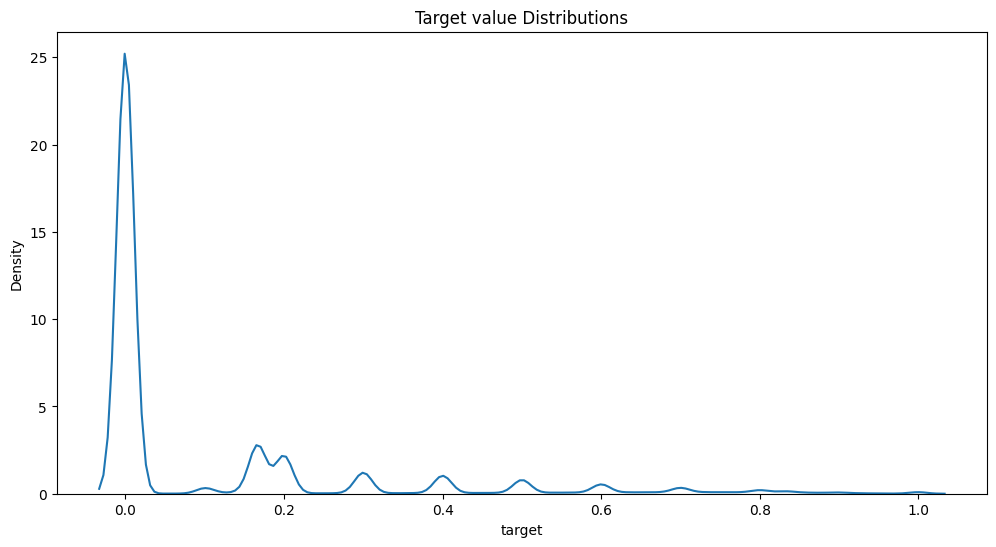

In [10]:
plt.figure(figsize=(12,6))
plt.title("Target value Distributions")
sns.distplot(train_df['target'], kde=True, hist=False, bins=240, label='target')
plt.show()

**We see that most of the comments present in the dataset are actually non-toxic (<0.5) and only a few of them are actually toxic (>0.5)**

### Explore Subtype Features
- severe_toxicity
- obscene
- threat
- insult
- identity_attack

In [11]:
# Modified a bit according to my needs
def plot_features_distribution(features, title, data):
    plt.figure(figsize=(12,6))
    plt.title(title)
    for feature in features:
        sns.distplot(data[feature],kde=True,hist=False, bins=240, label=feature)
    plt.xlabel('')
    plt.legend()
    plt.show()

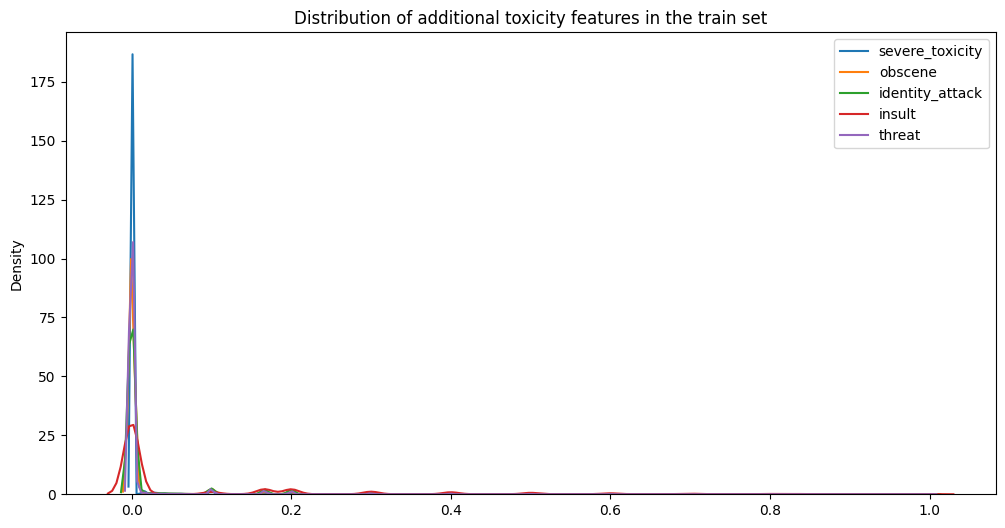

In [12]:
features = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
plot_features_distribution(features, "Distribution of additional toxicity features in the train set", train_df)

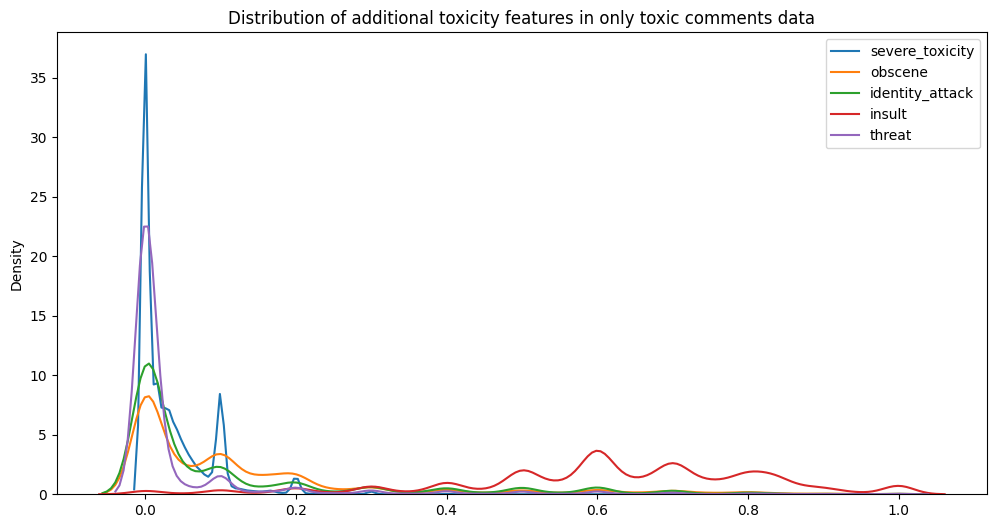

In [13]:
# Looking at the distribution of additional toxicity features on the comments that are actually considered toxic:
temp = train_df[train_df['target'] > 0.5]
plot_features_distribution(features, "Distribution of additional toxicity features in only toxic comments data", temp)

**We see that for toxic comments data, there are more insulting comments as compared to obscene comments**

In [14]:
# Getting the count of additonal toxicity features in toxic comments data(temp):
def get_comment_nature(row):
    # Extract type of toxic comment
    row = [row['severe_toxicity'], row['obscene'], row['identity_attack'], row['insult'], row['threat']]
    
    maxarg = np.argmax(np.array(row)) # Get the max value index.
    
    if maxarg == 0: return 'severe_toxicity'
    elif maxarg == 1: return 'obscene'
    elif maxarg == 2: return 'identity_attack'
    elif maxarg == 3: return 'insult'
    else: return 'threat'

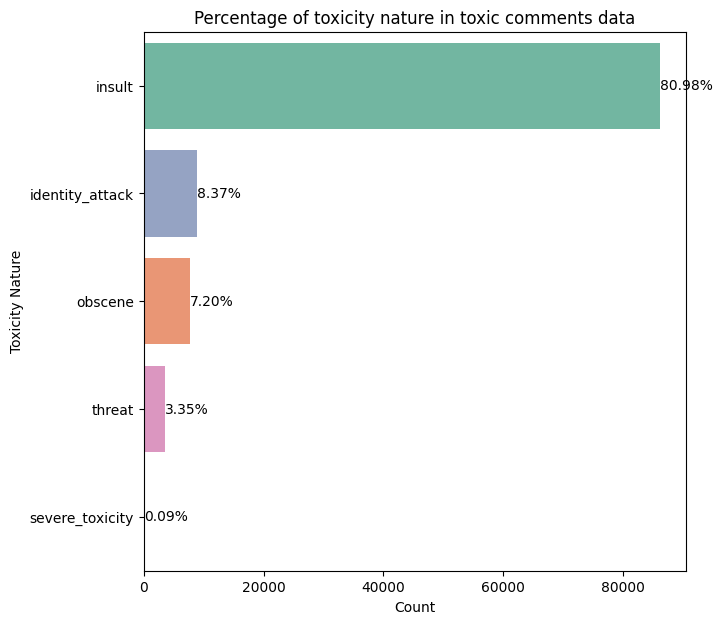

In [15]:
# Apply the get_comment_nature function to each row
x = temp.apply(get_comment_nature, axis=1) 

counts = x.value_counts()
order = x.value_counts().index

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
total = float(len(x))

# Set the palette to a different color scheme to distinguish between bars
palette = sns.color_palette("Set2", len(temp.columns))

# Plotting bars with aligned counts
bars = sns.countplot(y=x, hue=x, order=order, palette=palette, ax=ax, legend=False)

# Adding percentage labels on bars
for bar in bars.patches:
    width = bar.get_width()
    ax.text(width + 0.1, bar.get_y() + bar.get_height()/2, f'{width/total*100:.2f}%', va='center')

ax.set_title('Percentage of toxicity nature in toxic comments data')
ax.set_xlabel('Count')
ax.set_ylabel('Toxicity Nature')

plt.show()

# TODO: Check later if you need to add more EDA!

## load the saved preprocessesed data to save time

## Preprocessing Text and Train-Test Split:

In [16]:
train_df = train_df.sample(n=500000, random_state=42)
test_df = test_df.sample(n=80000, random_state=42)
print(train_df.shape)
print(test_df.shape)

(500000, 44)
(80000, 1)


In [17]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\peace\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))

def preprocess(text_string):
    text_string = text_string.lower() # Convert everything to lower case.
    text_string = re.sub('[^A-Za-z0-9]+', ' ', text_string) # Remove special characters and punctuations

    x = text_string.split()
    new_text = []

    for word in x:
        if word not in stop_words:
            new_text.append(stemmer.stem(word))

    text_string = ' '.join(new_text)
    return text_string

**pre-proccess the TRAIN data**

In [19]:
%%time
train_df['preprocessed_text'] = train_df['comment_text'].apply(preprocess)

CPU times: total: 1min 27s
Wall time: 1min 27s


In [20]:
train_df.shape

(500000, 45)

In [21]:
train_df["preprocessed_text"].head(10)

id
5760461                              knee jerk reaction know
5540729    dprk never bite prc hand feed lil kim know thi...
367935     find necessari spend much articl hat yai promo...
5653286    suicid subway tall build let ban subway tall b...
5855923    look like 6 peopl includ coach push alli posit...
532514                find us endors trump cours invent grow
5967175                 month payment putin count govern pay
340045     doubl credit drill babi drill enjoy anoth 40 y...
5229690    mani peopl fed immigr certain place world woul...
6261842    berni sander radic leftist establish candid ra...
Name: preprocessed_text, dtype: object

**pre-proccess the TEST data**

In [22]:
%%time
test_df['preprocessed_text'] = test_df['comment_text'].apply(preprocess)

CPU times: total: 14.2 s
Wall time: 14.3 s


In [23]:
test_df.shape

(80000, 2)

In [24]:
feature = train_df[['preprocessed_text']]
output = train_df[['target']]
X_train, X_cv, y_train, y_cv = train_test_split(feature, output)

print(X_train.shape)
print(X_cv.shape)
print(y_train.shape)
print(y_cv.shape)

(375000, 1)
(125000, 1)
(375000, 1)
(125000, 1)


In [25]:
X_train.head()

,preprocessed_text
id,
5744686,throughout histori suprem court rule mani thin...
6303980,els drop undi moon naw think anoth homeless bu...
499856,think progress incom tax right way go everybod...
6160847,cut back screen penni wise pound foolish true ...
5160751,first add tsb stori think tsb own properti foo...


In [26]:
X_cv.head()

,preprocessed_text
id,
747600,conserv lose record strong major countri still...
5437977,one sacrif countri sacrif countri ego
5697933,give first rate educ larg popul would otherwis...
990820,articl base fals assumpt posit taken trump ant...
4987287,clear idea econom fx work think foreign get mo...


In [27]:
X_test = test_df[['preprocessed_text']]
X_test.head()

,preprocessed_text
id,
7147522,actual read news comment
7168379,like chang 2nd amend otherwis shut eff
7130951,case lynch draft 1st round pick 3rd round late...
7132137,said better pain manag addict pain manag differ
7140361,money back room allianc hors trade busi intere...


In [ ]:
# Saving the files to csv so that we dont need to preprocess again.
X_train = X_train.to_pickle('X_train.pkl')
X_cv = X_cv.to_pickle('X_cv.pkl')
X_test = X_test.to_pickle('X_test.pkl')
y_train = y_train.to_pickle('y_train.pkl')
y_cv = y_cv.to_pickle('y_cv.pkl')
y_test = y_test.to_pickle('y_test.pkl')

NameError: name 'to_pickle' is not defined